# Pose Detection with HRNet

This notebook uses an open source project [lxy5513/hrnet](https://github.com/lxy5513/hrnet) to detect/track multi person poses on a given youtube video. The original HRNet code was [here](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install HRNet

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/lxy5513/hrnet.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
  !cd {project_name}/lib && make
  
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'tools'))
sys.path.append(join(project_name, 'lib'))
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

## Download pretrained models

In [ ]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  

pretrained_model_parent_directory = 'models/pytorch/pose_coco'
pretrained_model_path = join(project_name, pretrained_model_parent_directory, 'pose_hrnet_w48_256x192.pth')
if not exists(pretrained_model_path):
  # download the pretrained model
  !rm -rf {project_name}/models
  !mkdir -p {project_name}/{pretrained_model_parent_directory}
  download_from_google_drive('15T2XqPjW7Ex0uyC1miGVYUv7ULOxIyJI', pretrained_model_path)
  
yolo_pretrained_model_path = join(project_name, 'lib/detector/yolo/yolov3.weights')
if not exists(yolo_pretrained_model_path):
  # download the YOLO weights
  !cd {project_name}/lib/detector/yolo/ && wget -q https://pjreddie.com/media/files/yolov3.weights

## Detect poses on a test video

We are going to detect poses on the following youtube video:

Run an example: '/content/drive/My Drive/cs231n/project/dataset/biisc/videos/S020_F_SNEE_STD_FCE.avi'

In [ ]:
# execute HRNet on video frames
import cv2
import numpy as np
from utilitys import plot_keypoint, PreProcess
from lib.core.inference import get_final_preds
import torch
import config
import models
from config import cfg, update_config
from types import SimpleNamespace


update_config(cfg,
              SimpleNamespace(cfg = join(project_name, 'experiments/coco/hrnet/w48_256x192_adam_lr1e-3.yaml'),
                              opts = '',
                              modelDir='', logDir='', dataDir='', prevModelDir=''))
def model_load(config):
  model = models.pose_hrnet.get_pose_net(config, is_train=False)
  model_file_name  = join(project_name, 'models/pytorch/pose_coco/pose_hrnet_w48_256x192.pth')
  state_dict = torch.load(model_file_name)
  from collections import OrderedDict
  new_state_dict = OrderedDict()
  for k, v in state_dict.items():
      name = k # remove module.
      #  print(name,'\t')
      new_state_dict[name] = v
  model.load_state_dict(new_state_dict)
  model.eval()
  return model
pose_model = model_load(cfg).cuda()

from lib.detector.yolo.human_detector import human_bbox_get as yolo_det
from lib.detector.yolo.human_detector import load_model as yolo_model
human_model = yolo_model()

hmp_list = []

video_capture = cv2.VideoCapture()
if video_capture.open('/content/drive/My Drive/cs231n/project/dataset/biisc/videos/S020_F_SNEE_STD_FCE.avi'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break
      
    start = time.time()
    
    try:
      # TODO: Yolo needs RGB?
      bboxs, scores = yolo_det(frame, human_model)
      # bbox is coordinate location
      inputs, origin_img, center, scale = PreProcess(frame, bboxs, scores, cfg)
      
      with torch.no_grad():
        # compute output heatmap
        inputs = inputs[:,[2,1,0]]
        output = pose_model(inputs.cuda())
        # compute coordinate
        preds, maxvals = get_final_preds(
            cfg, output.clone().cpu().numpy(), np.asarray(center), np.asarray(scale))

      image = plot_keypoint(origin_img, preds, maxvals, 0.1)
      video_writer.write(image[:,:,::-1])
    except:
      print("no pose detected!")
      video_writer.write(frame)
    
    end = time.time()
    print("time: {}s, fps: {}".format(end-start, 1/(end-start)))
    
    hmp_list.append(output.clone().cpu().numpy())
    
  video_capture.release()
  video_writer.release()
  
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

Loading network.....
Network successfully loaded
time: 0.07405591011047363s, fps: 13.503311194315756
time: 0.06798005104064941s, fps: 14.710197840275805
time: 0.06333136558532715s, fps: 15.78996427374817
time: 0.06434154510498047s, fps: 15.542057598529652
time: 0.06803059577941895s, fps: 14.699268594418609
time: 0.06890177726745605s, fps: 14.513413726881089
time: 0.06060004234313965s, fps: 16.50163863479886
time: 0.06049346923828125s, fps: 16.530710051708915
time: 0.06111931800842285s, fps: 16.361439109353118
time: 0.06490325927734375s, fps: 15.407546726225462
time: 0.062456369400024414s, fps: 16.011177236306168
time: 0.06108975410461426s, fps: 16.36935709853295
time: 0.061574697494506836s, fps: 16.240437073835587
time: 0.06214118003845215s, fps: 16.092388322545744
time: 0.06476664543151855s, fps: 15.440046235795194
time: 0.06306767463684082s, fps: 15.855983366411492
time: 0.06289196014404297s, fps: 15.900283561041443
time: 0.06051278114318848s, fps: 16.525434480258777
time: 0.06132769

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

In [ ]:
len(hmp_list)


36

In [ ]:
hmp_list[0].shape

(1, 17, 64, 48)

In [ ]:
hmp = np.stack(hmp_list, axis = 1)
hmp = hmp.reshape(hmp.shape[1:])

In [ ]:
hmp.shape

(36, 17, 64, 48)

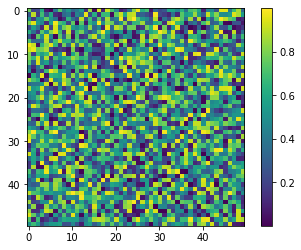

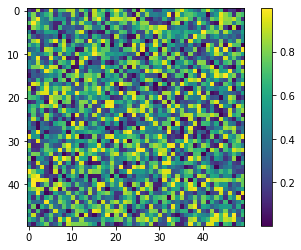

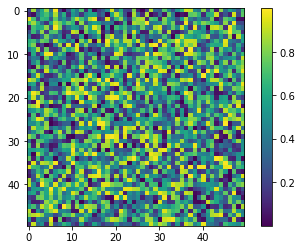

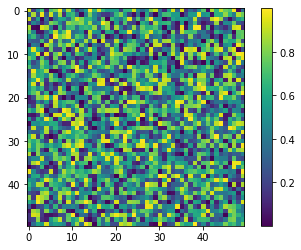

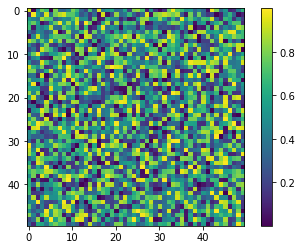

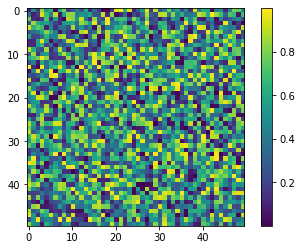

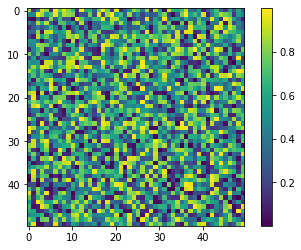

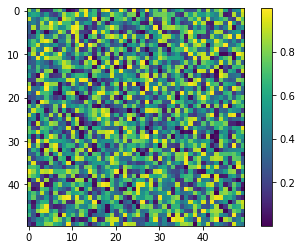

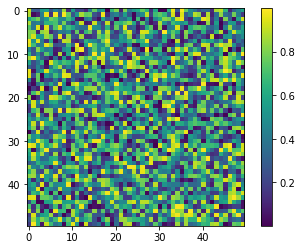

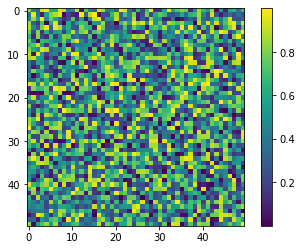

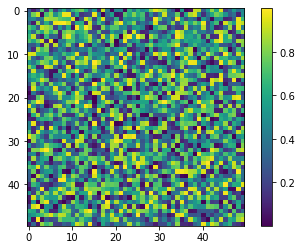

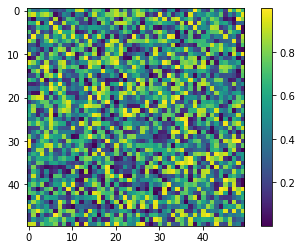

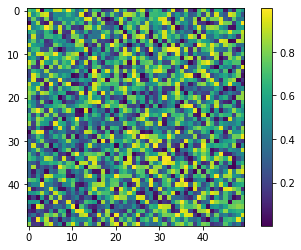

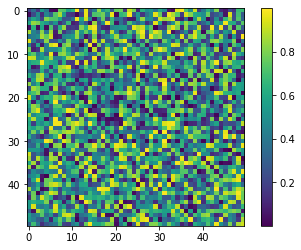

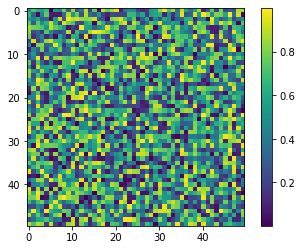

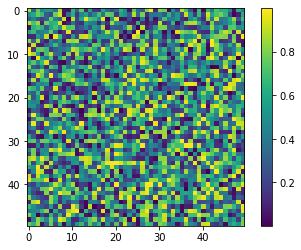

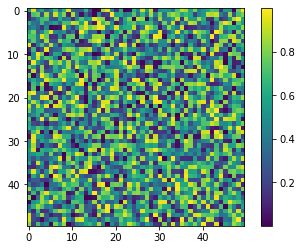

In [ ]:
for i in range(17):
  hmp_example = hmp_example = hmp[0, i, : , :]
  plt.imshow(np.random.random((50,50)))
  plt.colorbar()
  plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'cs231n/project/dataset/biisc/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
############Heatmap extraction

In [ ]:
vid_path = '/content/drive/My Drive/cs231n/project/dataset/biisc/videos/'
video_directory = os.path.join(vid_path)
videos = os.listdir(video_directory)
videos.remove('Frames')
len(videos)

1920

In [ ]:
hrnet_path = '/content/drive/My Drive/cs231n/project/dataset/biisc/shaped_data/hrnet/'
hr_directory = os.path.join(hrnet_path)
hrnet_list = os.listdir(hr_directory)
len(hrnet_list)

h_list = []
for h in hrnet_list:
  h_list.append(h[:-4])
len(h_list)

1860

In [ ]:
### Loop from the difference:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

final_list = Diff(videos, h_list)
len(final_list)

60

In [ ]:
# Add a loop to create heatmap for each video

from lib.detector.yolo.human_detector import human_bbox_get as yolo_det
from lib.detector.yolo.human_detector import load_model as yolo_model

frames_dir_path = '/content/drive/My Drive/cs231n/project/dataset/biisc/videos/'

update_config(cfg,
              SimpleNamespace(cfg = join(project_name, 'experiments/coco/hrnet/w48_256x192_adam_lr1e-3.yaml'),
                              opts = '',
                              modelDir='', logDir='', dataDir='', prevModelDir=''))
def model_load(config):
  model = models.pose_hrnet.get_pose_net(config, is_train=False)
  model_file_name  = join(project_name, 'models/pytorch/pose_coco/pose_hrnet_w48_256x192.pth')
  state_dict = torch.load(model_file_name)
  from collections import OrderedDict
  new_state_dict = OrderedDict()
  for k, v in state_dict.items():
      name = k # remove module.
      #  print(name,'\t')
      new_state_dict[name] = v
  model.load_state_dict(new_state_dict)
  model.eval()
  return model

for vid in final_list: ####### Loop starts here:

  print('######################## creating heatmap for ', vid)

  pose_model = model_load(cfg).cuda()


  human_model = yolo_model()

  hmp_list = []

  vid_path = os.path.join(frames_dir_path, vid)

  video_capture = cv2.VideoCapture(vid_path )
  if video_capture.open(vid_path):
    width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    !rm -f output.mp4 output.avi
    # can't write out mp4, so try to write into an AVI file
    video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
    while video_capture.isOpened():
      ret, frame = video_capture.read()
      if not ret:
        break
        
      start = time.time()
      
      try:
        # TODO: Yolo needs RGB?
        bboxs, scores = yolo_det(frame, human_model)
        # bbox is coordinate location
        inputs, origin_img, center, scale = PreProcess(frame, bboxs, scores, cfg)
        
        with torch.no_grad():
          # compute output heatmap
          inputs = inputs[:,[2,1,0]]
          output = pose_model(inputs.cuda())
          # compute coordinate
          preds, maxvals = get_final_preds(
              cfg, output.clone().cpu().numpy(), np.asarray(center), np.asarray(scale))

        image = plot_keypoint(origin_img, preds, maxvals, 0.1)
        video_writer.write(image[:,:,::-1])
      except:
        print("no pose detected!")
        video_writer.write(frame)
      
      end = time.time()
      print("time: {}s, fps: {}".format(end-start, 1/(end-start)))
      
      hmp_list.append(output.clone().cpu().numpy())
      
      
    video_capture.release()
    video_writer.release()
    
    !ffmpeg -y -loglevel info -i output.avi output.mp4
  else:
    print("can't open the given input video file!")
  hmp = np.stack(hmp_list, axis = 1)
  hmp = hmp.reshape(hmp.shape[1:])
  save_dir = os.path.join('/content/drive/My Drive/cs231n/project/dataset/biisc/shaped_data/hrnet/', vid)
  np.save(save_dir, hmp) 

Streaming output truncated to the last 5000 lines.
video:125kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.408715%
[libx264 @ 0x56450302be00] frame I:1     Avg QP:15.38  size:  6423
[libx264 @ 0x56450302be00] frame P:21    Avg QP:16.50  size:  2987
[libx264 @ 0x56450302be00] frame B:59    Avg QP:20.27  size:   983
[libx264 @ 0x56450302be00] consecutive B-frames:  2.5%  0.0%  3.7% 93.8%
[libx264 @ 0x56450302be00] mb I  I16..4: 21.2% 76.8%  1.9%
[libx264 @ 0x56450302be00] mb P  I16..4:  1.5% 19.8%  0.6%  P16..4: 25.9% 10.1% 12.3%  0.0%  0.0%    skip:29.7%
[libx264 @ 0x56450302be00] mb B  I16..4:  0.3%  3.6%  0.1%  B16..8: 33.1%  7.5%  1.2%  direct: 2.9%  skip:51.2%  L0:45.9% L1:50.9% BI: 3.3%
[libx264 @ 0x56450302be00] 8x8 transform intra:88.9% inter:85.3%
[libx264 @ 0x56450302be00] coded y,uvDC,uvAC intra: 47.8% 42.3% 4.2% inter: 8.6% 13.5% 2.7%
[libx264 @ 0x56450302be00] i16 v,h,dc,p: 34% 45% 19%  2%
[libx264 @ 0x56450302be00] i8 v,h,dc,ddl,ddr,vr,hd,